# Light travel time delay
A simple tutorial on how the finite speed of light affects exoplanet light curves and how to account for this in `starry`.

## Imports

In [1]:
from starry.kepler import Primary, Secondary, System
import numpy as np
import matplotlib.pyplot as pl

In [2]:
%matplotlib inline

## Instantiating a simple system

Let's instantiate a simple limb-darkened star and a hot Jupiter on a 10-day period with a dipole map:

In [4]:
star = Primary()
star[1] = 0.40
star[2] = 0.26
planet = Secondary()
planet.L = 1e-3
planet.r = 0.1
planet.porb = 10
planet.prot = 10
planet.a = 22
planet[1, 0] = 0.5

By default, `starry` does not compute the effects of light travel time. The main reason for this is that all the stuff in `starry` is unitless: the primary's physical properties (radius and luminosity) are fixed at unity, and the secondary's parameters are all specified relative to these quantities. In order to compute the light travel time within the system, `starry` needs to know the actual size of the orbits. Since all distances are measured relative to the primary's radius, to turn light travel effects on all you need to do is tell `starry` how big the primary is. This is done by setting the `r_m` (radius in meters) parameter of the `Primary` instance:

In [6]:
system = System(star, planet)
star.r_m = 0

I set it to zero for now, which tells `starry` the star's radius is **zero**. Quite unphysical, but the `r_m` parameter is **only** used to compute the light travel time, so this effectively tells `starry` that light travels across the system instantaneously. Let's plot the system light curve over one orbital period:

Transit: 0.000000
Eclipse: 0.500000


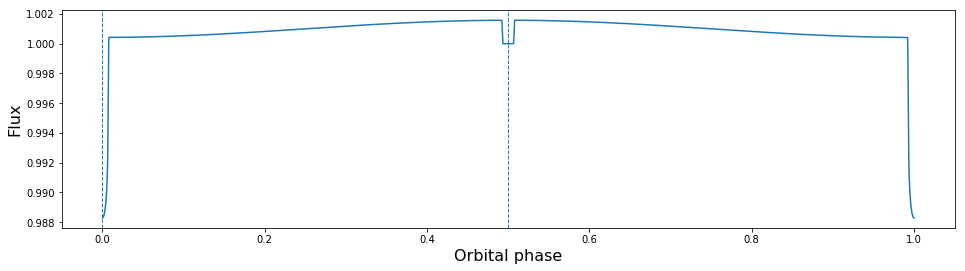

In [8]:
time = np.concatenate((np.linspace(0, 0.5, 10000, endpoint=False),
                       np.linspace(0.5, 4.5, 100, endpoint=False),
                       np.linspace(4.5, 5.5, 10000, endpoint=False),
                       np.linspace(5.5, 9.5, 100, endpoint=False),
                       np.linspace(9.5, 10, 10000)))
phase = time / 10.
system.compute(time)
fig, ax = pl.subplots(1, figsize=(16, 4))
ax.plot(phase, system.lightcurve);
ax.set_xlabel('Orbital phase', fontsize=16);
ax.set_ylabel('Flux', fontsize=16);
transit = phase[np.argmax(planet.Z)]
eclipse = phase[np.argmin(planet.Z)]
ax.axvline(transit, ls='--', lw=1);
ax.axvline(eclipse, ls='--', lw=1);
print("Transit: %.6f" % transit)
print("Eclipse: %.6f" % eclipse)

A couple remarks:

- I added higher time resolution near transit and secondary eclipse so we can time things accurately
- I computed and marked the phase corresponding to the largest value of `z` (when the planet is closest to the observer): this is the time of transit, accurate to within our time grid spacing
- I also computed and marked the phase corresponding to the smallest value of `z` (when the planet is farthest from the observer): this is the time of secondary eclipse

As expected, transit occurs at a phase of exactly 0 and eclipse at a phase of exactly 1/2.

## Accounting for the light travel time

Now, let's tell `starry` to compute the effects of light travel time by giving our star an actual physical radius. The `r_m` parameter is the radius of the star in meters, so if our star is a Sun-like star, we simply tell `starry`

In [9]:
star.r_m = 6.95700e8

Let's recompute and plot the light curve:

Transit: 0.999941
Eclipse: 0.500059


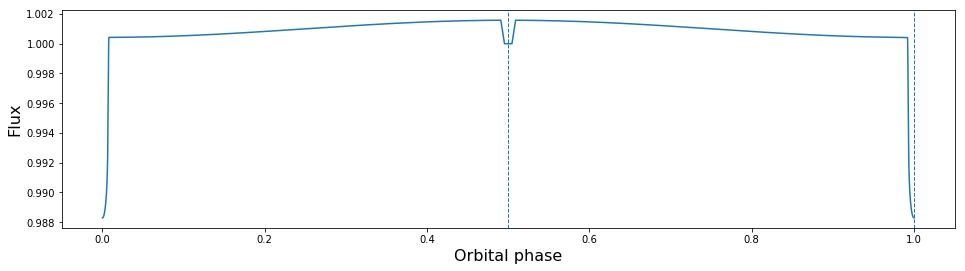

In [11]:
eps = 1e-3
time = np.concatenate((np.linspace(0, 0.5, 100000, endpoint=False),
                       np.linspace(0.5, 5 - eps, 100, endpoint=False),
                       np.linspace(5 - eps, 5 + eps, 1000000, endpoint=False),
                       np.linspace(5 + eps, 9.5, 100, endpoint=False),
                       np.linspace(9.5, 10, 100000)))
phase = time / planet.porb
system.compute(time)
fig, ax = pl.subplots(1, figsize=(16, 4))
ax.plot(phase, system.lightcurve);
ax.set_xlabel('Orbital phase', fontsize=16);
ax.set_ylabel('Flux', fontsize=16);
transit = phase[np.argmin(np.abs(planet.X) + (planet.Z < 0))]
eclipse = phase[np.argmin(np.abs(planet.X) + (planet.Z > 0))]
ax.axvline(transit, ls='--', lw=1);
ax.axvline(eclipse, ls='--', lw=1);
print("Transit: %.6f" % transit)
print("Eclipse: %.6f" % eclipse)

The effect is super tiny in this case, but there is now a small offset in both the time of transit and of secondary eclipse! In `starry`, the time delay is computed relative to the barycenter, so transits happen *early* (since the planet is closer to the observer than the barycenter) and eclipses happen *late* (since the planet is farther). We can verify that the phase difference between secondary eclipse and a phase of 0.5 is just `a / c`, the time light takes to travel from the planet to the barycenter:

In [12]:
print("Time delay from starry (s): %.8f" % ((eclipse - 0.5) * planet.porb * 86400))

Time delay from starry (s): 51.05324160


In [13]:
c = 299792458. # m / s
RSUN = 6.957e8 # m
a = planet.a * star.r_m
print("Time delay from common sense (s): %.8f" % (a / c))

Time delay from common sense (s): 51.05331903


Not bad! Note that they are in fact **slightly** different, for a rather subtle reason. There's actually no closed-form way to compute the light travel time delay at arbitrary points in the light curve! Let me clarify: it's (very) easy to compute what the delay `dt` is given knowledge of where the planet is in the orbit at time `t`. But that calculation tells me what the light curve will look like at time `t + dt`, when the information actually reaches the observer (well, technically, when it reaches the reference point). Our observations are at time `t`, not `t + dt`, so what we actually need to know is where the planet was in its orbit at time `t - dt`. This may sound easy, but if you think about it, we are essentially asking to know the position

$x'(t) = x\bigg(t - dt\Big(x'(t)\Big)\bigg)$

which is a transcendental equation! The difficulty boils down to the fact that $dt$ is a function of the planet's retarded position, so it's a function of the very variable whose value we seek. 

To get around this, what we do in `starry` is we Taylor expand the equation above to second order, so we get a pretty good approximation to $dt(x'(t))$. We then re-compute the orbital position at the retarded time and use that to compute light curves. So, long story short, the time delay computed by `starry` is not exact. In principle, we could take the expansion out to higher order. If you have an application that needs this extra accuracy, please let us know!

## Just for fun

Finally, just for fun, here's a bunch of light curves with ridiculous (and very unphysical) light travel time delays, obtained by setting the stellar radius to very large (and very unphysical) values. I'm only plotting the *planet* flux so we can better see the behaviour of the phase curve.

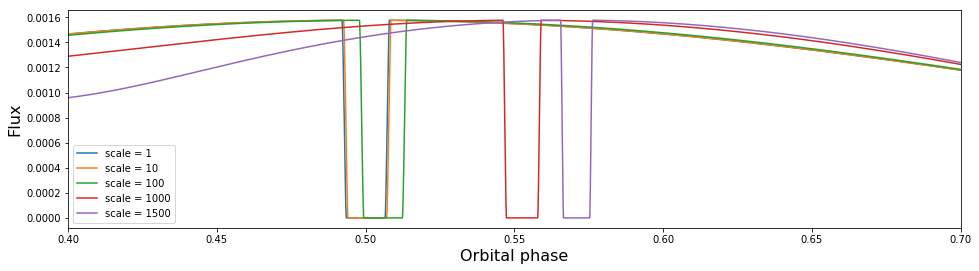

In [14]:
time = np.linspace(0, 10, 100000)
phase = time / planet.porb

fig, ax = pl.subplots(1, figsize=(16, 4))

for scale in [1, 10, 100, 1000, 1500]:
    star.r_m = 6.95700e8 * scale
    system.compute(time)
    ax.plot(phase, planet.lightcurve, label="scale = %d" % scale);

ax.set_xlim(0.4, 0.7)
ax.set_xlabel('Orbital phase', fontsize=16);
ax.set_ylabel('Flux', fontsize=16);
ax.legend();

The cool thing you can see from these is that the light travel time also affects the phase curves, although keep in mind the effect is very small! Remember that these are unphysical systems: the purple curve corresponds to a planet traveling at $0.5c$ (!!) You'd probably have all sorts of relativistic effects in that case that `starry` does not model.